In [ ]:
# Download dataset
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('housing.csv')
len(df)

20640

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


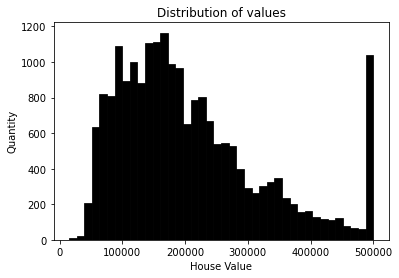

In [4]:
plt.figure(figsize=(6, 4))

sns.histplot(df.median_house_value, bins=40, color='black', alpha=1)
plt.ylabel('Quantity')
plt.xlabel('House Value')
plt.title('Distribution of values')

plt.show()

In [5]:
#For the rest of the homework, you'll need to use only these columns:

#'latitude',
#'longitude',
#'housing_median_age',
#'total_rooms',
#'total_bedrooms',
#'population',
#'households',
#'median_income',
#'median_house_value'
df = df[['latitude','longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
         'population', 'households', 'median_income', 'median_house_value']]


In [6]:
# Find a feature with missing values. How many missing values does it have?

df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [7]:
#What's the median (50% percentile) for variable 'population'?
df.quantile(
    q=0.5,                      # The percentile to calculate
    axis=0,                     # The axis to calculate the percentile on
    numeric_only=True,          # To calculate only for numeric columns
    interpolation='linear'      # The type of interpolation to use when the quantile is between 2 values
)

latitude                  34.2600
longitude               -118.4900
housing_median_age        29.0000
total_rooms             2127.0000
total_bedrooms           435.0000
population              1166.0000
households               409.0000
median_income              3.5348
median_house_value    179700.0000
Name: 0.5, dtype: float64

In [10]:
#Split the data
#    Shuffle the initial dataset, use seed 42.
#    Split your data in train/val/test sets, with 60%/20%/20% distribution.
#    Make sure that the target value ('median_house_value') is not in your dataframe.
#    Apply the log transformation to the median_house_value variable using the np.log1p() function.

np.random.seed(42)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [20]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [26]:
def prepare_X(df, value):
    if value == 'mean':
        df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].mean())
    else:
        df = df.fillna(value)
    X = df.values
    return X

In [29]:
#Question 3
#We need to deal with missing values for the column from Q1.
#We have two options: fill it with 0 or with the mean of this variable.
#Try both options. For each, train a linear regression model without regularization using the code from the lessons.
#For computing the mean, use the training only!
#Use the validation dataset to evaluate the models and compare the RMSE of each option.
#Round the RMSE scores to 2 decimal digits using round(score, 2)
#Which option gives better RMSE?

X_train = prepare_X(df_train, 0)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, 0)
y_pred = w_0 + X_val.dot(w)
round( rmse(y_val, y_pred), 2 )

0.33

In [30]:
X_train = prepare_X(df_train, 'mean')
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, 'mean')
y_pred = w_0 + X_val.dot(w)
round( rmse(y_val, y_pred), 2 )

0.33

In [31]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [34]:
#Question 4
#Now let's train a regularized linear regression.
#For this question, fill the NAs with 0.
#Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
#Use RMSE to evaluate the model on the validation dataset.
#Round the RMSE scores to 2 decimal digits.
#Which r gives the best RMSE?
#If there are multiple options, select the smallest r.


X_train = prepare_X(df_train, 0)
reg = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

for r in reg:
    w_0, w = train_linear_regression_reg(X_train, y_train, r)

    X_val = prepare_X(df_val, 0)
    y_pred = w_0 + X_val.dot(w)
    print( "r = {}; RMSE = {}.".format(r, round( rmse(y_val, y_pred), 2)))

r = 0; RMSE = 0.33.
r = 1e-06; RMSE = 0.33.
r = 0.0001; RMSE = 0.33.
r = 0.001; RMSE = 0.33.
r = 0.01; RMSE = 0.33.
r = 0.1; RMSE = 0.33.
r = 1; RMSE = 0.33.
r = 5; RMSE = 0.34.
r = 10; RMSE = 0.34.


In [39]:
#Question 5
#We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
#Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
#For each seed, do the train/validation/test split with 60%/20%/20% distribution.
#Fill the missing values with 0 and train a model without regularization.
#For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
#What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
#Round the result to 3 decimal digits (round(std, 3))

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []

for seed in seeds:
    np.random.seed(seed)

    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    y_train_orig = df_train.median_house_value.values
    y_val_orig = df_val.median_house_value.values
    y_test_orig = df_test.median_house_value.values

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
    X_train = prepare_X(df_train, 0)
    w_0, w = train_linear_regression(X_train, y_train)
    
    X_val = prepare_X(df_val, 0)
    y_pred = w_0 + X_val.dot(w)
    scores.append( rmse(y_val, y_pred) )

print(scores)
print( round( np.std( scores ), 3 ) )
    

[0.3388430480529589, 0.3362387255955875, 0.33209123188440237, 0.3405153609035516, 0.33890240665726906, 0.34348667257195153, 0.34519809530989876, 0.33959899274043825, 0.3466230873192811, 0.33659261241921284]
0.004


In [52]:
#Question 6
#Split the dataset like previously, use seed 9.
#Combine train and validation datasets.
#Fill the missing values with 0 and train a model with r=0.001.
#What's the RMSE on the test dataset?

np.random.seed(9)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

frames = [df_train, df_val]
df_train_val = pd.concat(frames)

y_train_val = np.hstack((y_train, y_val))


X_train_val = prepare_X(df_train_val, 0)
w_0, w = train_linear_regression(X_train_val, y_train_val)

X_test = prepare_X(df_test, 0)
y_pred = w_0 + X_test.dot(w)
print( rmse(y_test, y_pred) )

0.34531495071636736
